## Implement Outsourced Diffusion Sampling for amortized sampler from posterior distribution

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import deque

/home/taeyoung/miniconda3/envs/gtg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# seed reproduction
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# Define base distribution
mu1 = -1.0
sigma1 = 1.0
mu2 = 4.0
sigma2 = 1.0
mix_ratio = 0.4

mu_rf = -1.0
sigma_rf = 2.5

x_min = -7.5
x_max = 7.5

def p0(x):
    return torch.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi)

def p1(x):
    return mix_ratio * torch.exp(-0.5 * ((x - mu1) / sigma1) ** 2) / (sigma1 * np.sqrt(2 * np.pi)) + \
           (1 - mix_ratio) * torch.exp(-0.5 * ((x - mu2) / sigma2) ** 2) / (sigma2 * np.sqrt(2 * np.pi))
           
def r(x):
    return torch.exp(-0.5 * ((x - mu_rf) / sigma_rf) ** 2) / (sigma_rf * np.sqrt(2 * np.pi))

x_linspace = torch.linspace(x_min, x_max, 1000)
Z = torch.trapz(p1(x_linspace) * r(x_linspace), x_linspace)

def pr(x):
    return p1(x) * r(x) / Z

In [4]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples):
        self.data = torch.cat([
            torch.normal(mu1, sigma1, (int(num_samples * mix_ratio), 1)),
            torch.normal(mu2, sigma2, (int(num_samples * (1 - mix_ratio)), 1))
        ], dim=0)
        
        self.data_mean = self.data.mean(dim=0).unsqueeze(0)
        self.data_std = self.data.std(dim=0).unsqueeze(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

(-7.5, 7.5, 0.0, 0.3559475138783455)

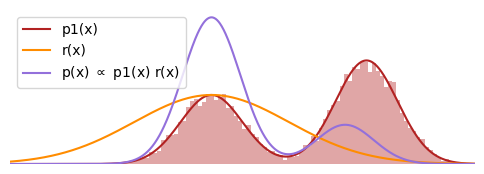

In [5]:
x_linspace = torch.linspace(x_min, x_max, 1000)

num_samples = 10000
dataset = ToyDataset(num_samples)

plt.figure(figsize=(6, 2))
plt.plot(x_linspace, p1(x_linspace), label='p1(x)', color="firebrick")
plt.plot(x_linspace, r(x_linspace), label='r(x)', color="darkorange")
plt.plot(x_linspace, pr(x_linspace), label='p(x) $\propto$ p1(x) r(x)', color="mediumpurple")
plt.hist(dataset.data.numpy(), bins=100, density=True, alpha=0.4, color='firebrick')
plt.xlim(x_min, x_max)
plt.legend()
plt.axis('off')

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
class FlowTrainer:
    def __init__(self, dataset, model, optimizer, batch_size, num_epochs, device):
        self.dataset = dataset
        self.model = model
        self.optimizer = optimizer
        
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        self.device = device
        
    def train(self):
        self.model.train()
        data_loader = torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)
        
        for epoch in range(self.num_epochs):
            for batch in data_loader:
                batch = batch.to(self.device)
                self.optimizer.zero_grad()
                loss = self.compute_loss(batch)
                loss.backward()
                self.optimizer.step()
                
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
                
    def compute_loss(self, batch):
        x0 = torch.randn_like(batch).to(self.device)
        x1 = batch
        
        t = torch.rand(x0.shape[0], 1).to(self.device)
        xt = self.sample_conditional_pt(x0, x1, t)
        ut = self.compute_conditional_vt(x0, x1)
        vt = self.model(torch.cat([xt, t], dim=-1))
        
        loss = F.mse_loss(ut, vt)
        return loss
    
    def sample_conditional_pt(self, x0, x1, t):
        mu_t = t * x1 + (1 - t) * x0
        return mu_t
    
    def compute_conditional_vt(self, x0, x1):
        return x1 - x0

In [7]:
dim = 1
batch_size = 256
num_flow_epochs = 100
hidden_dim = 128
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
flow_model = MLP(input_dim=dim+1, hidden_dim=hidden_dim, output_dim=dim).to(device)
flow_optimizer = optim.Adam(flow_model.parameters(), lr=learning_rate)
flow_trainer = FlowTrainer(dataset, flow_model, flow_optimizer, batch_size, num_flow_epochs, device)

flow_trainer.train()

Epoch 0, Loss: 3.1415
Epoch 10, Loss: 3.0355
Epoch 20, Loss: 6.5559
Epoch 30, Loss: 6.9317
Epoch 40, Loss: 6.0171
Epoch 50, Loss: 5.1049
Epoch 60, Loss: 2.2243
Epoch 70, Loss: 6.5820
Epoch 80, Loss: 3.2489
Epoch 90, Loss: 3.2494


In [9]:
num_timesteps = 100
x0 = torch.randn(num_samples, dim).to(device)
trajectory = []
xt = x0.clone()
for timestep in range(num_timesteps):
    t = torch.full((num_samples, 1), timestep / num_timesteps).to(device)
    vt = flow_model(torch.cat([xt, t], dim=-1))
    xt = xt + vt * (1.0 / num_timesteps)
    trajectory.append(xt.cpu().detach().numpy())
trajectory = np.stack(trajectory, axis=0)

(-7.5, 7.5, 0.4457254044439787, 0.0)

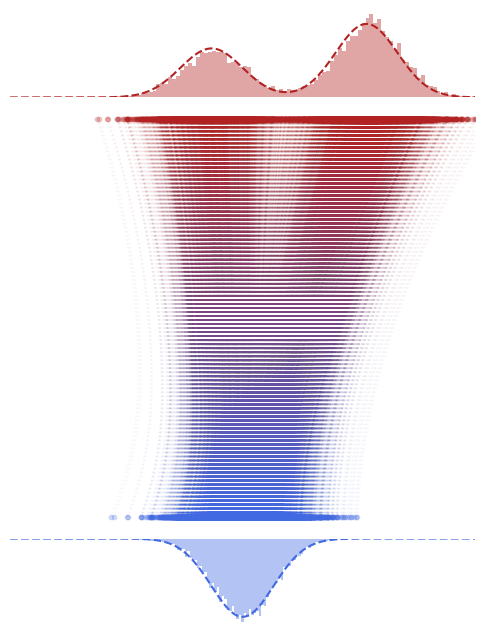

In [10]:
fig = plt.figure(figsize=(6, 8))
gs = fig.add_gridspec(3, 1, height_ratios=[0.2, 1.0, 0.2], hspace=0.01)

ax0 = fig.add_subplot(gs[0, 0])
plt.hist(trajectory[-1, :, 0], bins=100, density=True, alpha=0.4, color='firebrick')
ax0.plot(x_linspace, p1(x_linspace), label='p1(x)', linestyle="--", color="firebrick")
ax0.set_xlim(x_min, x_max)
ax0.axis("off")

# Add main scatter plot
ax1 = fig.add_subplot(gs[1, 0])
ax1.scatter(trajectory[-1, :, 0], np.ones_like(trajectory[-1, :, 0]), s=10, alpha=0.2, c="firebrick")
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["royalblue", "firebrick"])
ax1.scatter(trajectory[:, :, 0], np.linspace(0, 1, num_timesteps)[:, None] * np.ones_like(trajectory[:, :, 0]), s=0.2, alpha=0.05, c=np.linspace(0, 1, num_timesteps)[:, None] * np.ones_like(trajectory[:, :, 0]), cmap=cmap)
ax1.scatter(trajectory[0, :, 0], np.zeros_like(trajectory[0, :, 0]), s=10, alpha=0.2, c="royalblue")
ax1.set_xlim(x_min, x_max)
ax1.axis("off")

ax2 = fig.add_subplot(gs[2, 0])
plt.hist(trajectory[0, :, 0], bins=100, density=True, alpha=0.4, color='royalblue')
ax2.plot(x_linspace, p0(x_linspace), label='p0(x)', linestyle="--", color="royalblue")
ax2.set_xlim(x_min, x_max)
ax2.invert_yaxis()
ax2.axis("off")

In [ ]:
class DiffusionModel(nn.Module):
    def __init__(self, network, diffusion_steps, schedule="linear"):
        super(DiffusionModel, self).__init__()
        self.network = network
        self.logZ = torch.nn.Parameter(torch.zeros(1))
        self.diffusion_steps = diffusion_steps
        self.schedule = schedule
        if self.schedule == "linear":
            beta1 = 0.02
            beta2 = 1e-4
            beta_t = (beta1 - beta2) * torch.arange(diffusion_steps + 1, 0, step=-1) / (
                diffusion_steps
            ) + beta2
        alpha_t = 1 - torch.flip(beta_t, dims=[0])
        log_alpha_t = torch.log(alpha_t)
        alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
        sqrtab = torch.sqrt(alphabar_t)
        oneover_sqrta = 1 / torch.sqrt(alpha_t)
        sqrtmab = torch.sqrt(1 - alphabar_t)
        mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab
        self.register_buffer("beta_t", beta_t)
        self.register_buffer("alpha_t", torch.flip(alpha_t, dims=[0]))
        self.register_buffer("log_alpha_t", torch.flip(log_alpha_t, dims=[0]))
        self.register_buffer("alphabar_t", torch.flip(alphabar_t, dims=[0]))
        self.register_buffer("sqrtab", torch.flip(sqrtab, dims=[0]))
        self.register_buffer("oneover_sqrta", torch.flip(oneover_sqrta, dims=[0]))
        self.register_buffer("sqrtmab", torch.flip(sqrtmab, dims=[0]))
        self.register_buffer("mab_over_sqrtmab_inv", torch.flip(mab_over_sqrtmab_inv, dims=[0]))
        
        
class OutsourcedTrainer:
    def __init__(self, reward_fn, dim, model, flow_model, optimizer, batch_size, num_epochs, buffer_size, device):
        self.reward_fn = reward_fn
        self.dim = dim
        self.model = model
        self.flow_model = flow_model
        self.optimizer = optimizer
        
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        self.device = device

        self.buffer = deque(maxlen=buffer_size)
        
    def train(self):
        self.model.train()
        
        for epoch in range(self.num_epochs):
            # On-policy trajectories
            on_xs, on_logpfs, on_logpbs = self.sample_forward(self.batch_size)
            on_xs_unnorm, on_xs_logprobs = self.project(on_xs, num_timesteps)
            on_rs = self.reward_fn(on_xs_unnorm).squeeze() * torch.exp(on_xs_logprobs)
            
            # Off-policy trajectories
            if len(self.buffer) >= self.batch_size:
                idx = random.sample(range(len(self.buffer)), self.batch_size)
                
                off_xs = torch.stack([self.buffer[i][0] for i in idx]).to(self.device)
                off_rs = torch.stack([self.buffer[i][1] for i in idx]).to(self.device)
                off_logpfs, off_logpbs = self.sample_backward(off_xs)
            
                # Combine on-policy and off-policy trajectories
                xs = torch.cat((on_xs, off_xs), dim=0)
                rs = torch.cat((on_rs, off_rs), dim=0)

                logpfs = torch.cat((on_logpfs, off_logpfs), dim=0)
                logpbs = torch.cat((on_logpbs, off_logpbs), dim=0)
            else:
                xs = on_xs
                rs = on_rs
                
                logpfs = on_logpfs
                logpbs = on_logpbs
            
            # Compute TB loss
            self.optimizer.zero_grad()
            loss = self.compute_loss(logpfs, logpbs, rs)    
            loss.backward() 
            self.optimizer.step()
            
            # Update buffer
            for on_x, on_r in zip(on_xs, on_rs):
                self.buffer.append((on_x.detach(), on_r.detach()))
                
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
                
    def project(self, x0, num_timesteps):
        norm_dist = torch.distributions.Normal(
            torch.zeros_like(x0).to(self.device),
            torch.ones_like(x0).to(self.device)
        ) 
        log_prob = norm_dist.log_prob(x0).sum(dim=1) 
        
        xt = x0.clone()
        for timestep in range(num_timesteps):
            t = torch.full((x0.shape[0], 1), timestep / num_timesteps).to(self.device)
            vt = self.flow_model(torch.cat([xt, t], dim=-1))
            xt = xt + vt * (1.0 / num_timesteps)
        return xt, log_prob
    
    def compute_loss(self, logpfs, logpbs, rs):
        logZs = self.model.logZ.repeat(logpfs.shape[0])
        logrs = torch.log(rs + 1e-20).detach()
        loss = (logZs + logpfs - logpbs - logrs).pow(2).mean()
        return loss
    
    def sample_forward(self, batch_size):
        normal_dist = torch.distributions.Normal(
            torch.zeros(batch_size, self.dim).to(self.device),
            torch.ones(batch_size, self.dim).to(self.device)
        )
        
        x0 = normal_dist.sample()
        xt = x0.clone()
        
        logpfs = normal_dist.log_prob(x0).sum(dim=1)
        logpbs = torch.zeros(batch_size).to(self.device)
        for timestep in range(self.model.diffusion_steps):
            t_idx = torch.full((batch_size, 1), timestep).to(self.device)
            t = t_idx.float() / self.model.diffusion_steps
            epsilon_pred = self.model.network(torch.cat((xt, t), dim=1))
            next_xt = self.model.oneover_sqrta[t_idx] * (xt - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred.detach()) + torch.sqrt(self.model.beta_t[t_idx]) * torch.randn_like(xt).to(self.device)   
            
            pf_pi_dist = torch.distributions.Normal(
                self.model.oneover_sqrta[t_idx] * (xt - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred),
                torch.sqrt(self.model.beta_t[t_idx]) * torch.ones_like(xt).to(self.device)
            )
            
            pb_pi_dist = torch.distributions.Normal(
                torch.sqrt(self.model.alpha_t[t_idx]) * next_xt, 
                torch.sqrt(self.model.beta_t[t_idx]) * torch.ones_like(xt).to(self.device)
            )
            
            logpfs += pf_pi_dist.log_prob(next_xt).sum(dim=1)
            logpbs += pb_pi_dist.log_prob(xt).sum(dim=1)
            
            xt = next_xt
        return xt, logpfs, logpbs.detach()
    
    def sample_backward(self, x1):
        normal_dist = torch.distributions.Normal(
            torch.zeros(batch_size, self.dim).to(self.device),
            torch.ones(batch_size, self.dim).to(self.device)
        )
        
        xt = x1.clone()
        
        logpfs = torch.zeros(xt.shape[0]).to(self.device)
        logpbs = torch.zeros(xt.shape[0]).to(self.device)
        for timestep in range(self.model.diffusion_steps-1, -1, -1):
            t_idx = torch.full((xt.shape[0], 1), timestep).to(self.device)
            t = t_idx.float() / self.model.diffusion_steps
            
            pb_pi_dist = torch.distributions.Normal(
                torch.sqrt(self.model.alpha_t[t_idx]) * xt,
                torch.sqrt(self.model.beta_t[t_idx]) * torch.ones_like(xt).to(self.device)
            )
            
            xt_prev = pb_pi_dist.sample()
            epsilon_pred = self.model.network(torch.cat((xt_prev, t), dim=1))
            
            pf_pi_dist = torch.distributions.Normal(
                self.model.oneover_sqrta[t_idx] * (xt_prev - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred),
                torch.sqrt(self.model.beta_t[t_idx]) * torch.ones_like(xt).to(self.device)
            )
            
            logpfs += pf_pi_dist.log_prob(xt).sum(dim=1)
            logpbs += pb_pi_dist.log_prob(xt_prev).sum(dim=1)
            
            xt = xt_prev
        logpfs += normal_dist.log_prob(xt).sum(dim=1)
        return logpfs, logpbs.detach()
        
    def sample(self, sample_size):
        x0 = torch.randn(sample_size, self.dim).to(self.device)
        trajectory = []
        xt = x0.clone()
        for timestep in range(self.model.diffusion_steps):
            t_idx = torch.full((sample_size, 1), timestep, device=self.device)
            t = t_idx.float() / self.model.diffusion_steps
            epsilon_pred = self.model.network(torch.cat((xt, t), dim=-1))
            xt = self.model.oneover_sqrta[t_idx] * (xt - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred) + torch.sqrt(self.model.beta_t[t_idx]) * torch.randn_like(xt).to(self.device)   
            trajectory.append(xt.cpu().detach().numpy())
        trajectory = np.stack(trajectory, axis=0)
        return trajectory

In [12]:
num_outsourced_epochs = 1000
buffer_size = 5000

In [13]:
outsourced_network = MLP(input_dim=dim + 1, hidden_dim=hidden_dim, output_dim=dim).to(device)
diffusion_steps = 100
outsourced_model = DiffusionModel(outsourced_network, diffusion_steps).to(device)
outsourced_optimizer = optim.Adam(outsourced_model.parameters(), lr=learning_rate)
outsourced_trainer = OutsourcedTrainer(r, dim, outsourced_model, flow_model, outsourced_optimizer, batch_size, num_outsourced_epochs, buffer_size, device)

outsourced_trainer.train()

Epoch 0, Loss: 45.8193
Epoch 50, Loss: 10.1592
Epoch 100, Loss: 8.5872
Epoch 150, Loss: 8.0615
Epoch 200, Loss: 7.1230
Epoch 250, Loss: 7.0887
Epoch 300, Loss: 6.6335
Epoch 350, Loss: 5.9941
Epoch 400, Loss: 6.3373
Epoch 450, Loss: 6.1061
Epoch 500, Loss: 5.4906
Epoch 550, Loss: 5.2885
Epoch 600, Loss: 5.1927
Epoch 650, Loss: 5.0314
Epoch 700, Loss: 4.4552
Epoch 750, Loss: 4.3407
Epoch 800, Loss: 4.2699
Epoch 850, Loss: 4.0640
Epoch 900, Loss: 3.9987
Epoch 950, Loss: 3.7117


In [14]:
outsourced_trajectory = outsourced_trainer.sample(num_samples)
# x0 = torch.randn(num_samples, dim).to(device)
x0 = torch.from_numpy(outsourced_trajectory[-1, :]).float().to(device)
flow_trajectory = []
xt = x0.clone()
for timestep in range(num_timesteps):
    t = torch.full((num_samples, 1), timestep / num_timesteps).to(device)
    vt = flow_model(torch.cat([xt, t], dim=-1))
    xt = xt + vt * (1.0 / num_timesteps)
    flow_trajectory.append(xt.cpu().detach().numpy())
flow_trajectory = np.stack(flow_trajectory, axis=0)

(-7.5, 7.5, 0.6903940166420259, 0.0)

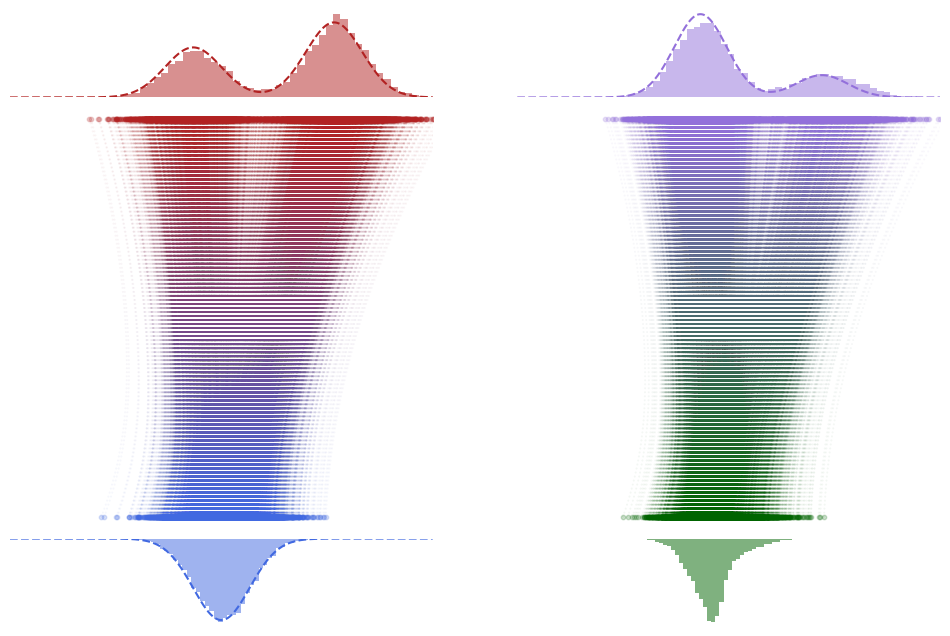

In [15]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 2, height_ratios=[0.2, 1.0, 0.2], hspace=0.01)

ax0 = fig.add_subplot(gs[0, 0])
plt.hist(trajectory[-1, :, 0], bins=50, density=True, color="firebrick", alpha=0.5)
ax0.plot(x_linspace, p1(x_linspace), label='p1(x)', linestyle="--", color="firebrick")
ax0.set_xlim(x_min, x_max)
ax0.axis("off")

# Add main scatter plot
ax1 = fig.add_subplot(gs[1, 0])
ax1.scatter(trajectory[-1, :, 0], np.ones_like(trajectory[-1, :, 0]), s=10, alpha=0.2, c="firebrick")
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["royalblue", "firebrick"])
ax1.scatter(trajectory[:, :, 0], np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(trajectory[:, :, 0]), s=0.2, alpha=0.05, c=np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(trajectory[:, :, 0]), cmap=cmap)
ax1.scatter(trajectory[0, :, 0], np.zeros_like(trajectory[0, :, 0]), s=10, alpha=0.2, c="royalblue")
ax1.set_xlim(x_min, x_max)
ax1.axis("off")

ax2 = fig.add_subplot(gs[2, 0])
plt.hist(trajectory[0, :, 0], bins=50, density=True, color="royalblue", alpha=0.5)
ax2.plot(x_linspace, p0(x_linspace), label='p0(x)', linestyle="--", color="royalblue")
ax2.set_xlim(x_min, x_max)
ax2.invert_yaxis()
ax2.axis("off")

ax3 = fig.add_subplot(gs[0, 1])
plt.hist(flow_trajectory[-1, :, 0], bins=50, density=True, color="mediumpurple", alpha=0.5)
ax3.plot(x_linspace, pr(x_linspace), label='p(x) $\propto$ p1(x) r(x)', linestyle="--", color="mediumpurple")
ax3.set_xlim(x_min, x_max)
ax3.axis("off")

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(flow_trajectory[-1, :, 0], np.ones_like(flow_trajectory[-1, :, 0]), s=10, alpha=0.2, c="mediumpurple")
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["darkgreen", "mediumpurple"])
ax4.scatter(flow_trajectory[:, :, 0], np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(flow_trajectory[:, :, 0]), s=0.2, alpha=0.05, c=np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(flow_trajectory[:, :, 0]), cmap=cmap)
ax4.scatter(flow_trajectory[0, :, 0], np.zeros_like(flow_trajectory[0, :, 0]), s=10, alpha=0.2, c="darkgreen")
ax4.set_xlim(x_min, x_max)
ax4.axis("off")

ax5 = fig.add_subplot(gs[2, 1])
plt.hist(flow_trajectory[0, :, 0], bins=50, density=True, color="darkgreen", alpha=0.5)
ax5.set_xlim(x_min, x_max)
ax5.invert_yaxis()
ax5.axis("off")